In [1]:
# Import cell

import torch

import numpy as np
import pandas as pd

from IPython.display import Image

# 1: Basics

## 1.1: Tensors

In [3]:
# Creating tensors, operating it and particularities

## Empty tensor
x = torch.empty(1) # 1-D empty tensor
x = torch.empty(2, 1) # 2-D empty tensor
# x = torch.empty(n-dimensional tensor) # n-D empty tensor

## Zeros tensor
x = torch.zeros(1) # 1-D zeros tensor

## Ones tensor
x = torch.ones(1) # 1-D ones tensor

## Defining type
x = torch.ones(2,2, dtype=torch.float16)
# print(x.dtype)

## Retrieving tensor size
# print(x.size())

## Creating tensor "from scratch"
x = torch.tensor([[2.5, 5], [1.7, 8]])

## Operations
x = torch.rand(2, 2)
y = torch.rand(2, 2)

### Arithmetic
z = x+y # Element-wise addition
z = torch.add(x,y) # Same result
y.add_(x) # Inplace element-wise addition; functions if "_" before its name make inplace ops

z = x-y # Element-wise subtraction
z = torch.sub(x, y) # Analogous as above
y.sub_(x) # Analogous as above

z = x*y # Element-wise multiplication
z = torch.mul(x, y) # Analogous as above
y.mul_(x) # Analogous as above

z = x / y # Element-wise division
z = torch.div(x, y) # Analogous as above
y.div_(x) # Analogous as above

### Slicing
z = x[:, 1]
z = x[1, 1]

### Reshaping
z = x.view(4)
z = x.view(-1, 2)

### Casting to numpy arrays
z = x.numpy()

### Casting from numpy arrays to pytorch tensors
z = np.array([[1, 3.4], [5, 8.9]])
w = torch.from_numpy(z)

### Working on GPU
# if torch.cuda_is_available():
#     gpu = torch.device("cuda")
#     x = torch.ones(1, 2, device=gpu) # Tensor allocated on GPU
#     y = torch.ones(5) # Tensor allocated on CPU
#     y = y.to(gpu) # Sending tensor instantiated on CPU to GPU

### Observation
#################################################################################
#    When dealing with tensors that it'll be needed to compute its gradients    #
#    (e.g in optimization), Pytorch requires defining it explicitly.            #
#################################################################################
# x = torch.ones(4, requires_grad=True) # requires_grad argument is False by default

---

## 1.2: Autograd

Autograd's package: used to ease the calculation of gradients. Its principle is based on Automatic Differentiation (autodiff)
which is a general method for automatically computing the derivative of a value. For more details, I highly recommend checking out
Prof. Roger Grosse lecture's slides¹ about the technique and the following medium post² about Pytorch's implementation of it.

1: https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf <br>
2: https://mustafaghali11.medium.com/how-pytorch-backward-function-works-55669b3b7c62

In [4]:
# First, let's create an input tensor
x = torch.rand(3, requires_grad=True) # Remember that it's necessary to enable requires_grad property

# After creating the input tensor, let's define
# an operation over this tensor.
y = 3*x+2 # Creates the computational graph

**Computational graph created after operating over the tensor:**

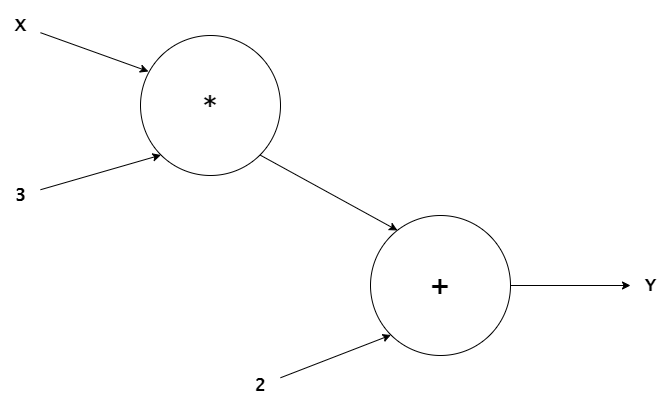

In [5]:
Image(filename="assets/images/compt_graph.png")

In [6]:
print("X:", x)
print("Y:", y)

X: tensor([0.2909, 0.2975, 0.4159], requires_grad=True)
Y: tensor([2.8726, 2.8925, 3.2477], grad_fn=<AddBackward0>)


As seen, tensor X has requires_grad property set as **True** and tensor Y has the last operation over X (addition) as its gradient function. 
In the next example, Z is a tensor computed multiplying Y by itself and your grad. function is the multiplication op.

In [7]:
z = y*y
print(z)

tensor([ 8.2519,  8.3667, 10.5478], grad_fn=<MulBackward0>)


For the sake of understanding, let's simplify assuming that our output tensor is 1-dimensional.

In [8]:
z = z.mean()
print(z)

tensor(9.0555, grad_fn=<MeanBackward0>)


So, in order to compute Z gradient w.r.t. X, we call the Z backward() function and X grad property.

In [9]:
z.backward()
print(x.grad, '\nThree gradients of Z w.r.t. X, because X is a 3-D tensor')

tensor([5.7452, 5.7851, 6.4955]) 
Three gradients of Z w.r.t. X, because X is a 3-D tensor


On the other hand, if we have a multi-dimensional output tensor, we need to specify a gradient vector as an argument of backward() function
towards the correct execution. In this sense, it's used a 'ones' tensor as the gradient vector in the Jacobian-vector Product - which is
a way for computing partial derivatives, used inside autograd. For more details, please check the references in the head of this section.

In [10]:
y = 3*x+2
z = y*y
size = list(z.size())
init_grad_vec = torch.ones(size)

z.backward(init_grad_vec)
print(x.grad)

tensor([22.9809, 23.1402, 25.9819])


Though Pytorch allocate every gradient of a specific variable, sometimes it's essential to reset our gradients.

In [11]:
for i in range(3):
    y = 3*x + 2
    z = y*y

    z.backward(init_grad_vec)
    print("Step {} gradient vector: {}".format(i+1, x.grad))

_ = x.grad.zero_()

Step 1 gradient vector: tensor([40.2165, 40.4954, 45.4684])
Step 2 gradient vector: tensor([57.4522, 57.8505, 64.9548])
Step 3 gradient vector: tensor([74.6878, 75.2057, 84.4413])


In [12]:
for i in range(3):
    y = 3*x + 2
    z = y*y

    z.backward(init_grad_vec)
    print("Step {} gradient vector: {}".format(i+1, x.grad))
    
    _ = x.grad.zero_()

Step 1 gradient vector: tensor([17.2357, 17.3552, 19.4864])
Step 2 gradient vector: tensor([17.2357, 17.3552, 19.4864])
Step 3 gradient vector: tensor([17.2357, 17.3552, 19.4864])


Sometimes during training we might want to stop tracking variables from the gradient perspective. There are three ways to do so.
(As seen below, none of tensors have the property requires_grad in it)

In [13]:
# First way
x.requires_grad_(False)
# print(x)

# Second way
x.detach()
# print(x)

# Third way
with torch.no_grad():
    y = x + 2
#     print(y)

---

## 1.3: Backpropagation

Backpropagation is an algorithm used to compute gradients of functions w.r.t. parameters that appears previously 
to the function computation, and them is backpropagated to which one of them.

Let's suppose we have a first degree function (w/o linear coefficient, i.e. $y = f(x) = {\theta}x$). Suppose our parameter $\theta = 5$.
In our computational graph Pytorch's framework, such operation should be seen as follows:

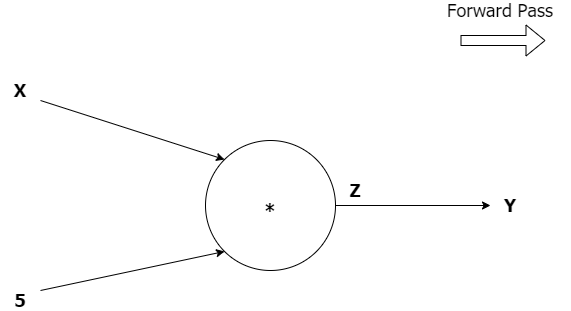

In [152]:
Image(filename="assets/images/bprop_ex_compt_graph_1.png")

Here we have a multiplication operation and the attribution of this result in Y variable (an identity). In the background,
the result of the first operation is seen as an intermediate variable - here called Z -, and them it's attributed to Y, completing
the forward pass stage. Given that, to compute the gradient of Y w.r.t. X it's necessary to operate using the chain rule of calculus,
in order to compute the gradient of Y w.r.t the intermediate variable Z.

---

Briefly, the chain rule assures (not restricted to a 2-step computation. In fact, it's valid, in general, for n-steps):



$\dfrac{dy}{dz}*\dfrac{dz}{dx} = \dfrac{dy}{dx}$

---

The complete computation graph with the forward and backward pass is depicted below:

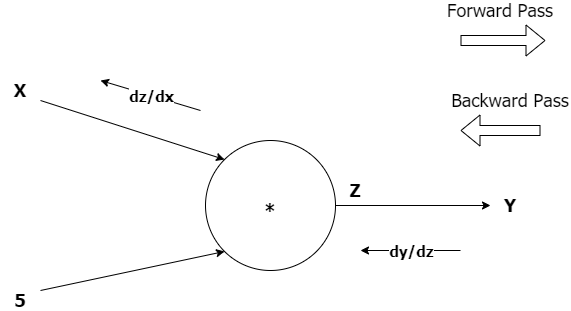

In [153]:
Image(filename="assets/images/bprop_ex_compt_graph_2.png")

The Pytorch implementation of the backpropagation is as simple as follows:

In [150]:
# Instantiate data point
x = torch.tensor([4], dtype=torch.float32, requires_grad=True)

# Computational graph
y = 5*x # dy/dx = 5

# Backward pass
y.backward()
dy = x.grad

print(f'dy/dx = {int(dy.item())} (as expected!)')

dy/dx = 5 (as expected!)


## 1.4: Gradient Descent Algorithm

Toward to wrap all of these concepts and enable the algorithm to learn the paremeters' values, the gradient descent algorithm
this task*. This algorithm can be divided in four steps:

* Forward pass
* Loss computation
* Backward pass
* Update parameters

The only which wasn't introduced is the loss computation. In short, since the learning is being supervised, i.e. it's known a priori the correct
output's value, one way to compute 'how much' the approximation function being learned is 'wrong' is computing the error between its
output and the correct value. Here, the loss function used is the well-known Mean Squared Error (MSE)**. 

\* The purpose here isn't to explain all the details of gradient descent algorithm.

\** In the examples below the problem is a regression one.

---

First, let's code it from scratch, using Numpy:

In [146]:
# Set data points
x = np.array([1, 2, 3, 4, 5], dtype=np.float32)
y = np.array([5, 10, 15, 20, 25], dtype=np.float32)

# Randomly initialize parameter
theta = np.random.randn(1)

# Define hyperparameters
lr = 0.01
num_iters = 100

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = theta*x

    # Loss computation
    J = np.mean((y_hat - y)**2) / 2

    # Backward pass
    dJ = np.mean(x*(y_hat - y))

    # Update parameter
    theta = theta - lr*dJ

    # Print loss function
    if i % 20 == 0:
        print(f"{i}th iter. Error (J): {J:.3f} | Parameter: {theta[0]:.3f}")

20th iter. Error (J): 1.785 | Parameter: 4.493
40th iter. Error (J): 0.017 | Parameter: 4.951
60th iter. Error (J): 0.000 | Parameter: 4.995
80th iter. Error (J): 0.000 | Parameter: 5.000
100th iter. Error (J): 0.000 | Parameter: 5.000


Now with Pytorch's Autograd (untill gradient computation):

In [145]:
# Set data points
x = torch.tensor([1, 2, 3, 4, 5], dtype=torch.float32)
y = torch.tensor([5, 10, 15, 20, 25], dtype=torch.float32)

# Randomly initialize parameter
theta = torch.rand(1, requires_grad=True)

# Define hyperparameters
lr = 0.01
num_iters = 100

for i in range(1, num_iters+1):
    # Forward pass
    y_hat = theta*x

    # Loss computation
    J = torch.mean((y_hat - y)**2 / 2)

    # Backward pass
    J.backward() # dJ/dtheta

    # Update parameter
    ## Remember that we don't want to track this operation in our computational graph. Given that
    ## we should wrap our update operation inside the torch.no_grad(), as explained before.
    with torch.no_grad():
        theta -= lr*theta.grad

    # Zero theta gradients
    theta.grad.zero_()

    # Print loss function and theta updating
    if i % 20 == 0:
        print(f"{i}th iter. Error (J): {J:.3f} | Parameter: {theta.item():.3f}")

20th iter. Error (J): 1.379 | Parameter: 4.554
40th iter. Error (J): 0.013 | Parameter: 4.957
60th iter. Error (J): 0.000 | Parameter: 4.996
80th iter. Error (J): 0.000 | Parameter: 5.000
100th iter. Error (J): 0.000 | Parameter: 5.000


---